Removed letterbox: Top=235px, Bottom=235px


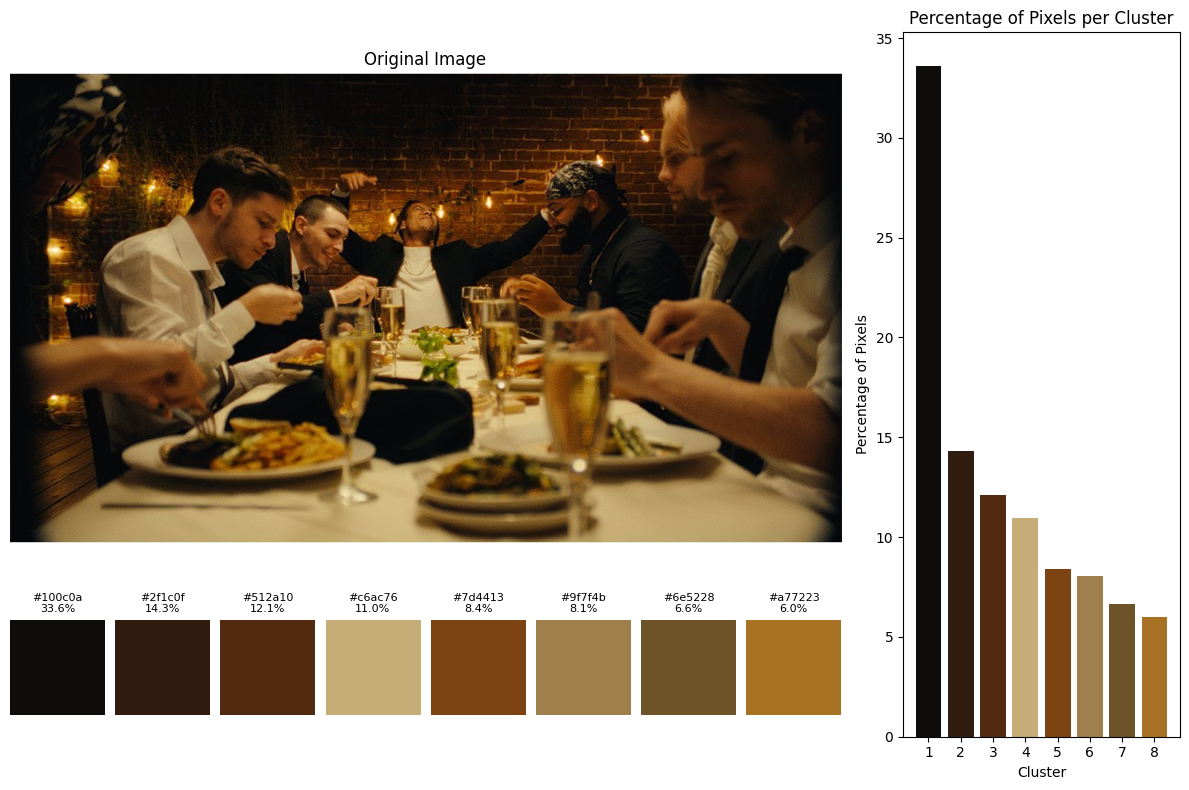

In [12]:
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt
from sklearn.cluster import KMeans
from skimage import color
from collections import Counter
import matplotlib.gridspec as gridspec

def is_similar(row, tolerance=10):
    """
    Check if all pixels in the row are similar within the given tolerance.
    """
    # Compute the difference between max and min for each channel
    diff = row.max(axis=0) - row.min(axis=0)
    return np.all(diff < tolerance)

def find_letterbox_height(image_np, tolerance=10, min_height=10, from_top=True):
    """
    Find the height of the letterbox from the top or bottom.
    """
    height, width, _ = image_np.shape
    letterbox_height = 0
    range_y = range(height) if from_top else range(height-1, -1, -1)
    
    for y in range_y:
        row = image_np[y, :, :]
        if is_similar(row, tolerance):
            letterbox_height +=1
        else:
            break
    # Ensure the detected letterbox is at least min_height pixels
    if letterbox_height >= min_height:
        return letterbox_height
    else:
        return 0

def remove_letterbox(image_np, tolerance=10, min_letterbox_height=10):
    """
    Detect and remove letterboxing from the top and bottom of the image.
    """
    top_height = find_letterbox_height(image_np, tolerance, min_letterbox_height, from_top=True)
    bottom_height = find_letterbox_height(image_np, tolerance, min_letterbox_height, from_top=False)
    
    if top_height > 0 or bottom_height > 0:
        cropped_image = image_np[top_height: image_np.shape[0] - bottom_height, :, :]
        print(f"Removed letterbox: Top={top_height}px, Bottom={bottom_height}px")
        return cropped_image
    else:
        print("No letterbox detected.")
        return image_np

# Step 1: Load the image
# imagePath = "myenv/img/cameronmarygold/2023-10-13_22-52-59_CyW0A9fPySK/387799770_18392162299048990_5074269383753542983_n.jpg"
# image = Image.open(imagePath[6:])
imagePath = "/Users/greyson/Projects/custom_gallery/gallery/public/img/cameronmarygold/2021-07-06_16-54-00_CQ_j8VorM1y/209772164_1970922413072622_4634697276599521314_n.jpg"

image = Image.open(imagePath)
image_np = np.array(image)

# Ensure the image is in RGB format
if image.mode != 'RGB':
    image = image.convert('RGB')
    image_np = np.array(image)

# Remove alpha channel if present
if image_np.shape[2] == 4:
    image_np = image_np[:, :, :3]

# *** Added Section: Detect and Remove Letterbox ***
# Parameters can be adjusted based on the expected letterbox characteristics
tolerance = 15           # Tolerance for color similarity (0-255)
min_letterbox_height = 10  # Minimum height in pixels to consider as letterbox

image_np = remove_letterbox(image_np, tolerance, min_letterbox_height)

# Step 2: Normalize and convert to LAB color space
image_normalized = image_np / 255.0
image_lab = color.rgb2lab(image_normalized)

# Step 3: Reshape image data for clustering
pixels_lab = image_lab.reshape(-1, 3)

# Step 4: Perform k-means clustering with k=8
k = 8  # Set the number of clusters
kmeans = KMeans(n_clusters=k, random_state=42)
kmeans.fit(pixels_lab)

# Step 5: Process cluster centers
cluster_centers_lab = kmeans.cluster_centers_
cluster_centers_rgb = color.lab2rgb(cluster_centers_lab.reshape(1, -1, 3))
cluster_centers_rgb = np.squeeze(cluster_centers_rgb)
cluster_centers_rgb_uint8 = np.clip(cluster_centers_rgb * 255, 0, 255).astype(int)

# Step 6: Quantify and visualize cluster sizes
labels = kmeans.labels_
counts = Counter(labels)
total_pixels = sum(counts.values())

# Sort clusters by the number of pixels
sorted_counts = counts.most_common()
sorted_cluster_indices = [item[0] for item in sorted_counts]
sorted_cluster_sizes = [item[1] for item in sorted_counts]
sorted_cluster_percentages = [(count / total_pixels) * 100 for count in sorted_cluster_sizes]
sorted_colors_rgb = np.array([cluster_centers_rgb_uint8[i] for i in sorted_cluster_indices])

# Prepare colors for bar charts (normalized to [0, 1])
bar_colors = sorted_colors_rgb / 255
cluster_numbers = range(1, k + 1)

# Create a figure with GridSpec
fig = plt.figure(figsize=(12, 8))
gs = gridspec.GridSpec(nrows=2, ncols=2, width_ratios=[3, 1], height_ratios=[4, 1])

# Display the original image in the left column, top row
ax_image = fig.add_subplot(gs[0, 0])
ax_image.imshow(image_np)
ax_image.axis('off')
ax_image.set_title('Original Image')

# Plot color swatches underneath the image in the left column, bottom row
gs_swatches = gridspec.GridSpecFromSubplotSpec(1, k, subplot_spec=gs[1, 0])
for i in range(k):
    ax = fig.add_subplot(gs_swatches[0, i])
    swatch = np.zeros((50, 50, 3), dtype=int)
    swatch[:, :] = sorted_colors_rgb[i]
    ax.imshow(swatch)
    ax.axis('off')
    hex_color = '#{:02x}{:02x}{:02x}'.format(*sorted_colors_rgb[i])
    percentage = sorted_cluster_percentages[i]
    ax.set_title(f"{hex_color}\n{percentage:.1f}%", fontsize=8)

# Plot the bar chart in the right column, spanning both rows
ax_bar = fig.add_subplot(gs[:, 1])
ax_bar.bar(cluster_numbers, sorted_cluster_percentages, color=bar_colors)
ax_bar.set_xlabel('Cluster')
ax_bar.set_ylabel('Percentage of Pixels')
ax_bar.set_title('Percentage of Pixels per Cluster')
ax_bar.set_xticks(cluster_numbers)

plt.tight_layout()
plt.show()